# Projeto Covid19 - Rio de Janeiro - RJ

Modelos para previsão municipio RJ para curto prazo (horizonte 7-10 dias)

### Bibliotecas

In [1]:
import requests
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import io
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from pandasgui import show
import time
import matplotlib

## Dados casos confirmados e mortes

In [2]:
data_rio_url = 'https://pcrj.maps.arcgis.com/sharing/rest/content/items/403b86903da64d1982292168d6bfa25f/data'
response = requests.get(data_rio_url).content

In [3]:
data_rio = pd.read_csv(data_rio_url, low_memory=False)#
#data_rio = pd.read_csv('data/RJ/db_PainelRioCovid.csv',low_memory=False)
# Renaming the columns
rename_dict = {'classificacao_final':'Classificacao_final',
               'dt_notific':'Data_notificacao',
               'dt_inicio_sintomas':'Data_inicio_sintomas',
               'bairro_resid_estadia':'Bairro_residencia_estadia',
               'ap_residencia_estadia':'Aps_residencia_estadia',
               'sexo': 'Sexo',
               'faixa_etaria': 'Faixa_etaria',
               'evolucao': 'Evolucao_caso',
               'dt_evolucao': 'Data_evolucao',
               'raca_cor': 'Raca_cor',
               'Data_atualizacao': 'Data_atualizacao',
               'sistema':'Sistema_origem'}
data_rio.rename(columns = rename_dict, inplace=True)

data_rio['Data_notificacao'] = pd.to_datetime(data_rio['Data_notificacao'])
data_rio['Data_inicio_sintomas'] = pd.to_datetime(data_rio['Data_inicio_sintomas'])
data_rio['Data_evolucao'] = pd.to_datetime(data_rio['Data_evolucao'])

# Tratando valores nulos
days = datetime.timedelta(5)
data_rio['Data_notificacao'] = data_rio['Data_notificacao'].fillna(data_rio['Data_inicio_sintomas'] + days)
data_rio['Data_inicio_sintomas'] = data_rio['Data_inicio_sintomas'].fillna(data_rio['Data_notificacao'] - days)

data_rio = data_rio.set_index('Data_notificacao')
data_rio = data_rio.sort_index()
print("Shape of dataset: ", data_rio.shape)
data_rio

Shape of dataset:  (250161, 11)


,classificação_final,Data_inicio_sintomas,Bairro_residencia_estadia,Aps_residencia_estadia,Sexo,Faixa_etaria,Evolucao_caso,Data_evolucao,Raca_cor,Data_atualizacao,Sistema_origem
Data_notificacao,,,,,,,,,,,
2020-01-12,CONFIRMADO,2020-01-07,BARRA DA TIJUCA,4.0,M,NaN,Recuperado,NaT,Ignorado,04/22/2021,ESUS
2020-01-13,CONFIRMADO,2020-12-19,JARDIM GUANABARA,3.1,F,De 10 a 19,Recuperado,NaT,Branca,04/22/2021,ESUS
2020-01-21,CONFIRMADO,2020-01-16,SANTA CRUZ,5.3,F,De 40 a 49,recuperado,2020-01-30,Branca,22/04/2021,SIVEP
2020-01-24,CONFIRMADO,2020-01-20,RIACHUELO,3.2,M,De 40 a 49,recuperado,2021-04-15,Parda,22/04/2021,SIVEP
2020-02-11,CONFIRMADO,2020-11-27,JACAREPAGUA,4.0,M,De 30 a 39,Recuperado,NaT,Preta,04/22/2021,ESUS
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21,CONFIRMADO,2021-03-05,CAMPO GRANDE,5.2,F,De 20 a 29,Recuperado,NaT,Ignorado,04/22/2021,ESUS
2021-04-21,CONFIRMADO,2021-04-18,COPACABANA,2.1,M,De 40 a 49,Ativo,NaT,Branca,04/22/2021,ESUS
2021-04-21,CONFIRMADO,2021-04-13,MARE,3.1,F,De 40 a 49,Ativo,NaT,Branca,04/22/2021,ESUS


In [4]:
#gui = show(data_rio)

In [5]:
#valores ainda nulos
data_rio.isnull().sum()

classificação_final               0
Data_inicio_sintomas              0
Bairro_residencia_estadia         0
Aps_residencia_estadia            0
Sexo                              0
Faixa_etaria                   3605
Evolucao_caso                    32
Data_evolucao                209227
Raca_cor                          0
Data_atualizacao                  0
Sistema_origem                    0
dtype: int64

### Total de casos confirmados por data de início dos sintomas:

In [6]:
#data_rio[data_rio.Data_inicio_sintomas.between('2020-01-01', datetime.datetime.today().strftime('%Y-%m-%d'))]
today = datetime.datetime.today().strftime('%Y-%m-%d')
outlier = data_rio.query('Data_inicio_sintomas < "2020-01-01" |  Data_inicio_sintomas > "today"').index
data_rio = data_rio.drop(outlier)

In [7]:
# plotting moving average (window = N past observations)
confirmados = data_rio.groupby('Data_inicio_sintomas')['classificação_final'].count()
confirmados = pd.DataFrame(confirmados)
media_movel = confirmados.rolling(window=7,min_periods=1).mean()

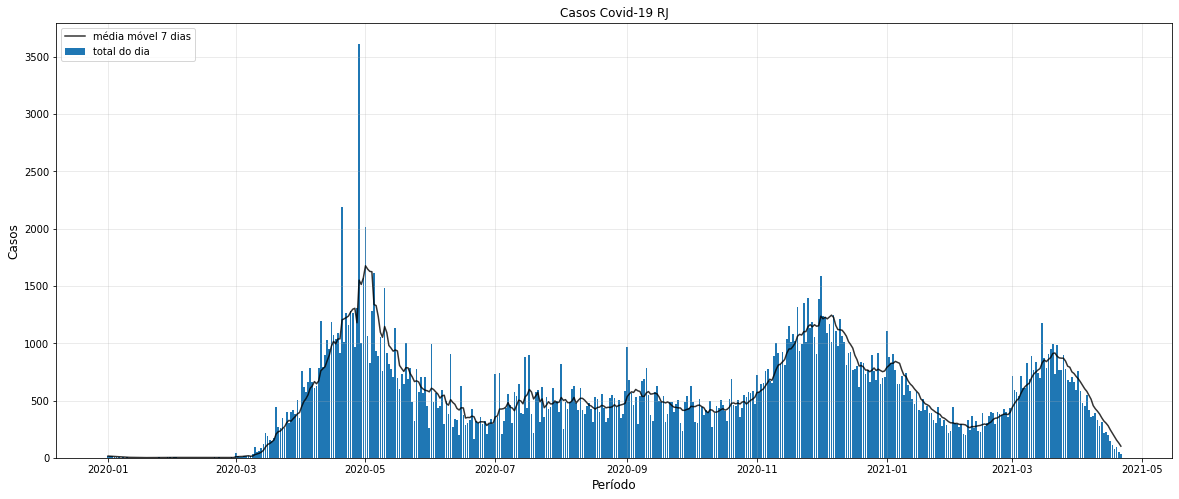

In [8]:
fig,ax= plt.subplots(figsize = (20, 8))
ax.bar(data_rio['Data_inicio_sintomas'].value_counts().keys(), data_rio['Data_inicio_sintomas'].value_counts().values, label='total do dia')
ax.plot(media_movel, color = "black", alpha = .8, label = "média móvel 7 dias")
ax.grid(alpha = .3)
#xtick_location = data_rio['Data_inicio_sintomas'].value_counts().index.tolist()[::7]
#xtick_labels =data_rio['Data_inicio_sintomas'].value_counts().index[::7]
#ax.set_xticks(xtick_location)
#ax.set_xticklabels(xtick_labels, rotation=90, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'})
ax.set_ylabel('Casos',fontsize = 12)
ax.set_xlabel('Período',fontsize = 12)
ax.set_title("Casos Covid-19 RJ", fontsize = 12)
ax.legend(loc = "upper left", fontsize = 10)
plt.show()

In [9]:
len(confirmados)

455

### Casos graves e óbitos por data de início dos sintomas:

In [10]:
obitos = data_rio.query('Evolucao_caso == "óbito" |  Evolucao_caso != Evolucao_caso')
obitos_confirmados = obitos.groupby('Data_inicio_sintomas')['classificação_final'].count()
obitos_confirmados = pd.DataFrame(obitos_confirmados)
media_movel_obitos = obitos_confirmados.rolling(window=7,min_periods=1).mean()

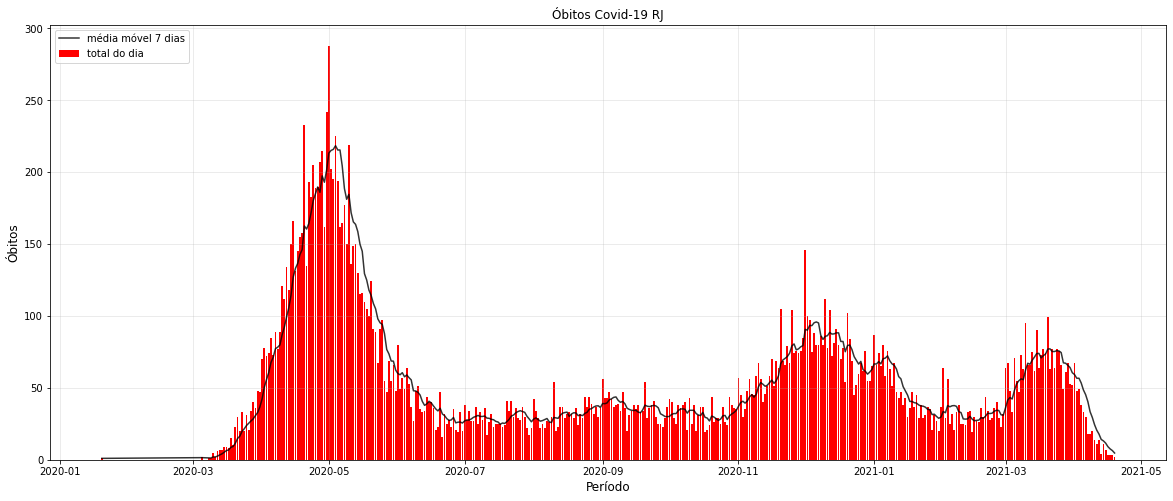

In [11]:
fig,ax= plt.subplots(figsize = (20, 8))
ax.bar(obitos['Data_inicio_sintomas'].value_counts().keys(), obitos['Data_inicio_sintomas'].value_counts().values, color='red', label='total do dia')
ax.plot(media_movel_obitos, color = "black", alpha = .8, label = "média móvel 7 dias")
ax.grid(alpha = .3)
ax.set_ylabel('Óbitos',fontsize = 12)
ax.set_xlabel('Período',fontsize = 12)
ax.set_title("Óbitos Covid-19 RJ", fontsize = 12)
ax.legend(loc = "upper left", fontsize = 10)
plt.show()

## Dados mobilidade urbana


### Dados Apple

In [12]:
quote_page = 'https://covid19-static.cdn-apple.com/covid19-mobility-data/current/v3/index.json'

page = requests.get(quote_page).content
csv_path = json.loads(page)['regions']['en-us']['csvPath']
base_path = json.loads(page)['basePath']
apple_url = 'https://covid19-static.cdn-apple.com%s%s' %(base_path, csv_path)

response = requests.get(apple_url).content

In [13]:
#pd.set_option('display.max_columns', None)
data=pd.read_csv(apple_url)
data = data.set_index(['region','transportation_type']).transpose()
data.drop(data.index[:4], inplace=True)
data.index = pd.to_datetime(data.index)
data.bfill(inplace=True)
apple_data = data

/home/fabricio/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



In [14]:
apple_data['Rio de Janeiro']

transportation_type,driving,transit,walking
2020-01-13,100.00,100.00,100.00
2020-01-14,97.43,101.55,105.01
2020-01-15,101.13,98.34,105.56
2020-01-16,104.05,101.47,98.62
2020-01-17,110.67,97.29,96.15
...,...,...,...
2021-05-21,103.38,56.13,85.82
2021-05-22,102.81,43.52,80.08
2021-05-23,84.25,38.11,61.37
2021-05-24,78.90,57.84,68.20


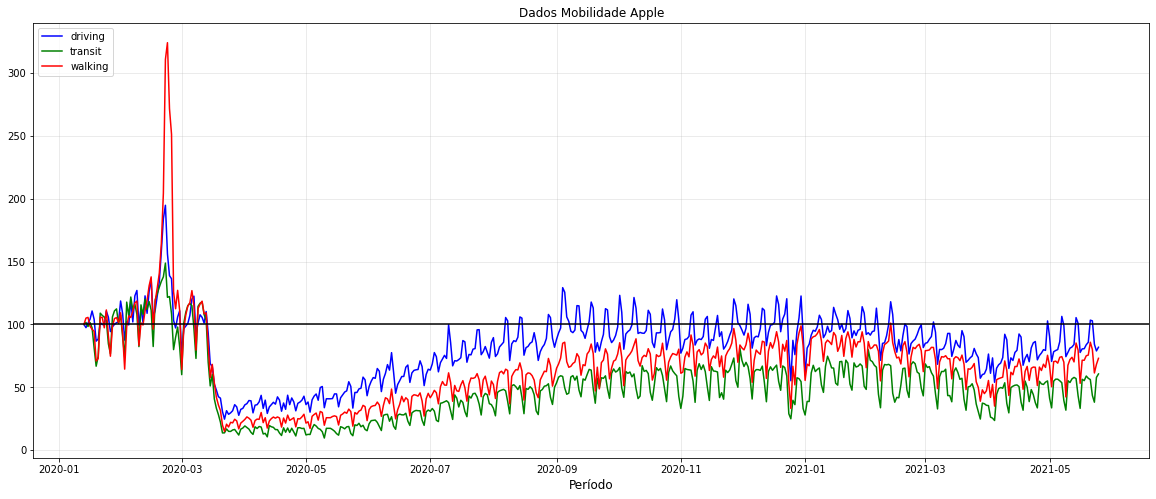

In [15]:
fig,ax= plt.subplots(figsize = (20, 8))
ax.plot(apple_data['Rio de Janeiro']['driving'], color = "blue", label = "driving")
ax.plot(apple_data['Rio de Janeiro']['transit'], color = "green", label = "transit")
ax.plot(apple_data['Rio de Janeiro']['walking'], color = "red", label = "walking")
ax.axhline(y=100, color = "black",linestyle='-')
ax.grid(alpha = .3)
#ax.set_ylabel('',fontsize = 12)
ax.set_xlabel('Período',fontsize = 12)
ax.set_title("Dados Mobilidade Apple", fontsize = 12)
ax.legend(loc = "upper left", fontsize = 10)
plt.show()

### Dados Google

In [16]:
google_url = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'
response = requests.get(google_url).content

In [17]:
data = pd.read_csv(google_url, low_memory=False)
# Renaming the columns
rename_dict = {'date':'Data',
               'country_region_code':'Code_Pais',
               'country_region':'Regiao_Pais',
               'sub_region_1':'Estado_Pais',
               'sub_region_2':'Cidade_Pais',
               'retail_and_recreation_percent_change_from_baseline': 'Varejo_Lazer',
               'grocery_and_pharmacy_percent_change_from_baseline': 'Mercados_Farmacias',
               'parks_percent_change_from_baseline': 'Parques',
               'transit_stations_percent_change_from_baseline': 'Estacao_transporte',
               'workplaces_percent_change_from_baseline': 'Local_trabalho',
               'residential_percent_change_from_baseline': 'Residencial'}
data.rename(columns = rename_dict, inplace=True)
data = data.set_index('Data')
data.index = pd.to_datetime(data.index)
google_data = data.query('Cidade_Pais == "Rio de Janeiro"') 
google_data 

,Code_Pais,Regiao_Pais,Estado_Pais,Cidade_Pais,metro_area,iso_3166_2_code,census_fips_code,place_id,Varejo_Lazer,Mercados_Farmacias,Parques,Estacao_transporte,Local_trabalho,Residencial
Data,,,,,,,,,,,,,,
2020-02-15,BR,Brazil,State of Rio de Janeiro,Rio de Janeiro,NaN,NaN,NaN,ChIJC7UkQv5-mQAR7llshDwliPk,7.0,7.0,17.0,13.0,6.0,-2.0
2020-02-16,BR,Brazil,State of Rio de Janeiro,Rio de Janeiro,NaN,NaN,NaN,ChIJC7UkQv5-mQAR7llshDwliPk,0.0,-1.0,0.0,6.0,-1.0,1.0
2020-02-17,BR,Brazil,State of Rio de Janeiro,Rio de Janeiro,NaN,NaN,NaN,ChIJC7UkQv5-mQAR7llshDwliPk,4.0,7.0,1.0,13.0,19.0,-3.0
2020-02-18,BR,Brazil,State of Rio de Janeiro,Rio de Janeiro,NaN,NaN,NaN,ChIJC7UkQv5-mQAR7llshDwliPk,-1.0,0.0,8.0,12.0,14.0,-2.0
2020-02-19,BR,Brazil,State of Rio de Janeiro,Rio de Janeiro,NaN,NaN,NaN,ChIJC7UkQv5-mQAR7llshDwliPk,1.0,5.0,6.0,12.0,14.0,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-18,BR,Brazil,State of Rio de Janeiro,Rio de Janeiro,NaN,NaN,NaN,ChIJC7UkQv5-mQAR7llshDwliPk,-33.0,16.0,-34.0,-21.0,-10.0,11.0
2021-05-19,BR,Brazil,State of Rio de Janeiro,Rio de Janeiro,NaN,NaN,NaN,ChIJC7UkQv5-mQAR7llshDwliPk,-29.0,24.0,-27.0,-21.0,-8.0,10.0
2021-05-20,BR,Brazil,State of Rio de Janeiro,Rio de Janeiro,NaN,NaN,NaN,ChIJC7UkQv5-mQAR7llshDwliPk,-30.0,27.0,-19.0,-20.0,-6.0,10.0


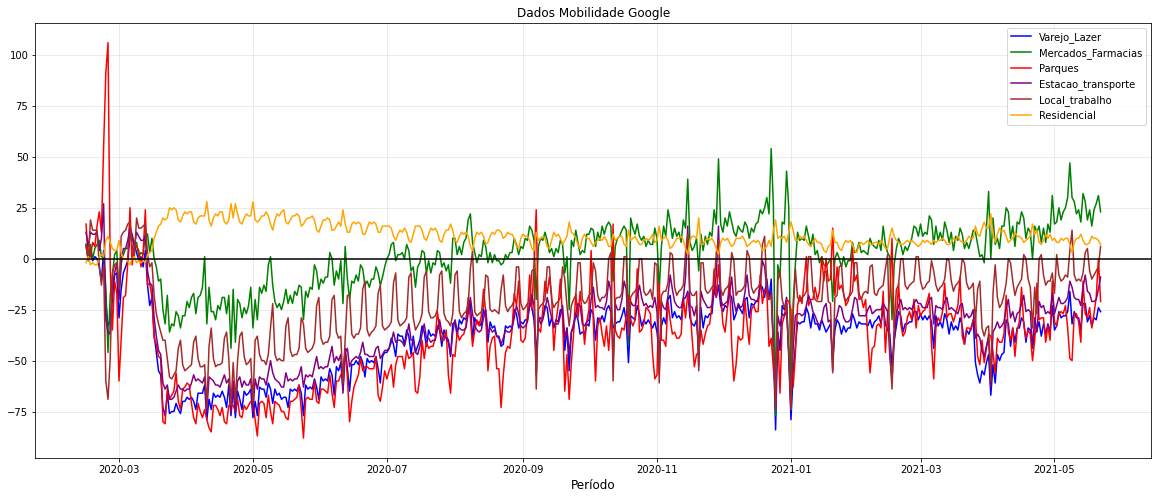

In [18]:
fig,ax= plt.subplots(figsize = (20, 8))
ax.plot(google_data['Varejo_Lazer'], color = "blue", label = "Varejo_Lazer")
ax.plot(google_data['Mercados_Farmacias'], color = "green", label = "Mercados_Farmacias")
ax.plot(google_data['Parques'], color = "red", label = "Parques")
ax.plot(google_data['Estacao_transporte'], color = "purple", label = "Estacao_transporte")
ax.plot(google_data['Local_trabalho'], color = "brown", label = "Local_trabalho")
ax.plot(google_data['Residencial'], color = "orange", label = "Residencial")
ax.axhline(y=0, color = "black",linestyle='-')
ax.grid(alpha = .3)
#ax.set_ylabel('',fontsize = 12)
ax.set_xlabel('Período',fontsize = 12)
ax.set_title("Dados Mobilidade Google", fontsize = 12)
ax.legend(loc = "upper right", fontsize = 10)
plt.show()



## Dados taxa de ocupação leitos

In [19]:
planilha = pd.ExcelFile('data/RJ/PAINEL CORONAVIRUS COVID-19.xlsx')
taxa_ocupacao = pd.read_excel(planilha)

/home/fabricio/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [20]:
colunas = taxa_ocupacao.iloc[1].values.tolist()
dados = taxa_ocupacao.values[2:-1].tolist()
ocupacao = pd.DataFrame(dados,columns =colunas)
ocupacao = ocupacao.set_index('Semana Epidemiológica')
ocupacao.head()

,Enfermaria,UTI
Semana Epidemiológica,,
2020-32 08-02 - 08-08,0.141414,0.336066
2020-33 08-09 - 08-15,0.310345,0.325581
2020-34 08-16 - 08-22,0.399698,0.477516
2020-35 08-23 - 08-29,0.338912,0.451557
2020-36 08-30 - 09-05,0.308046,0.426446


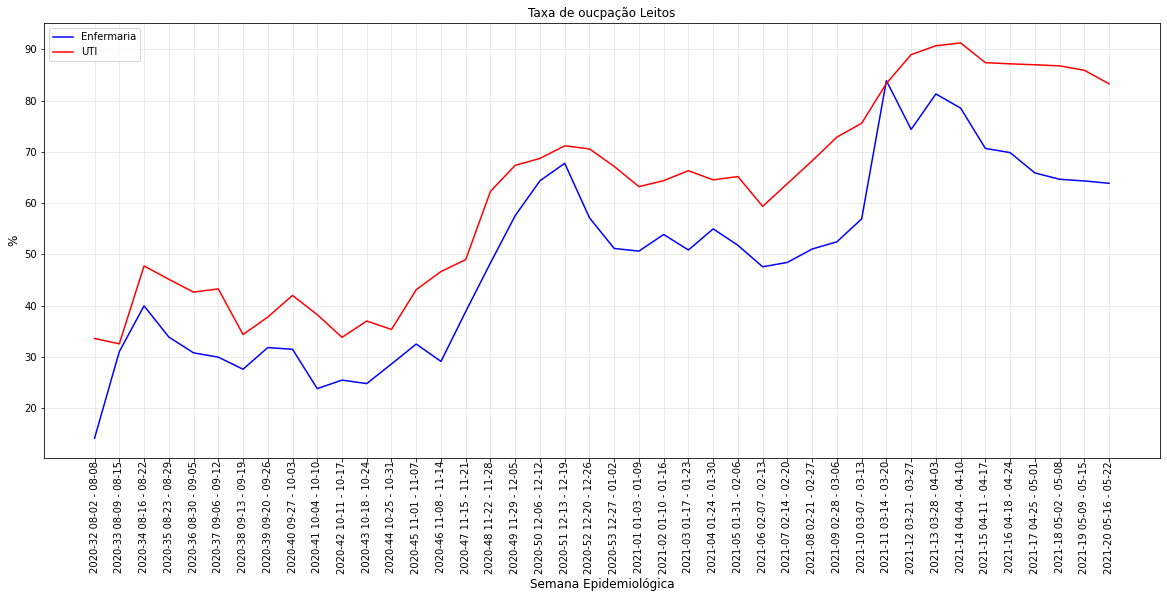

In [21]:
fig,ax= plt.subplots(figsize = (20, 8))
ax.plot([o*100 for o in ocupacao['Enfermaria']], color='blue', label='Enfermaria')
ax.plot([o*100 for o in ocupacao['UTI']], color='red', label='UTI')
ax.grid(alpha = .3)
ax.set_ylabel('%',fontsize = 12)
xtick_location = np.arange(0, len(ocupacao), step=1)
xtick_labels =ocupacao.index.values.tolist()
ax.set_xticks(xtick_location)
ax.set_xticklabels(xtick_labels, rotation=90, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'})
ax.set_xlabel('Semana Epidemiológica',fontsize = 12)
ax.set_title("Taxa de oucpação Leitos", fontsize = 12)
ax.legend(loc = "upper left", fontsize = 10)
plt.show()

### Registro de Ocupação Hospitalar COVID-19 - SUS

O módulo Internações foi desenvolvido para registro da ocupação de leitos clínicos e de Unidade de Terapia Intensiva (UTI) SUS destinados para atendimento aos pacientes com casos suspeitos ou confirmados da COVID-19 (ocupação SRAG / COVID-19)

https://opendatasus.saude.gov.br/dataset/registro-de-ocupacao-hospitalar

https://s3-sa-east-1.amazonaws.com/ckan.saude.gov.br/Leitos/2021-05-12/esus-vepi.LeitoOcupacao.csv

In [22]:
fields = ["_id","cnes","origem","_p_usuario","validado", "excluido","_created_at","_updated_at"]

data_sus = pd.read_csv('data/RJ/esus-vepi.LeitoOcupacao.csv',low_memory=False)
data_sus.drop(fields,axis='columns',inplace=True)

In [23]:

data_sus['dataNotificacao'] = pd.to_datetime(data_sus['dataNotificacao'],format='%Y-%m-%d')
data_sus = data_sus.query('municipio == "Rio de Janeiro"')
data_sus = data_sus.groupby(pd.Grouper(key='dataNotificacao',freq='D')).sum() 
#data_sus = data_sus.set_index('dataNotificacao')
data_sus = data_sus.sort_index()
data_sus = data_sus.head(data_sus.shape[0] -1)
data_sus

,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas
dataNotificacao,,,,,,,,
2020-01-01 00:00:00+00:00,99.0,12.0,7.0,0.0,0.0,0.0,0.0,0.0
2020-01-02 00:00:00+00:00,100.0,13.0,6.0,0.0,1.0,0.0,0.0,0.0
2020-01-03 00:00:00+00:00,51.0,28.0,24.0,26.0,0.0,4.0,0.0,0.0
2020-01-04 00:00:00+00:00,21.0,22.0,21.0,22.0,0.0,4.0,0.0,0.0
2020-01-05 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2021-05-07 00:00:00+00:00,3272.0,890.0,428.0,589.0,15.0,34.0,8.0,16.0
2021-05-08 00:00:00+00:00,3253.0,955.0,443.0,642.0,22.0,28.0,5.0,8.0
2021-05-09 00:00:00+00:00,3241.0,960.0,441.0,644.0,22.0,38.0,1.0,14.0


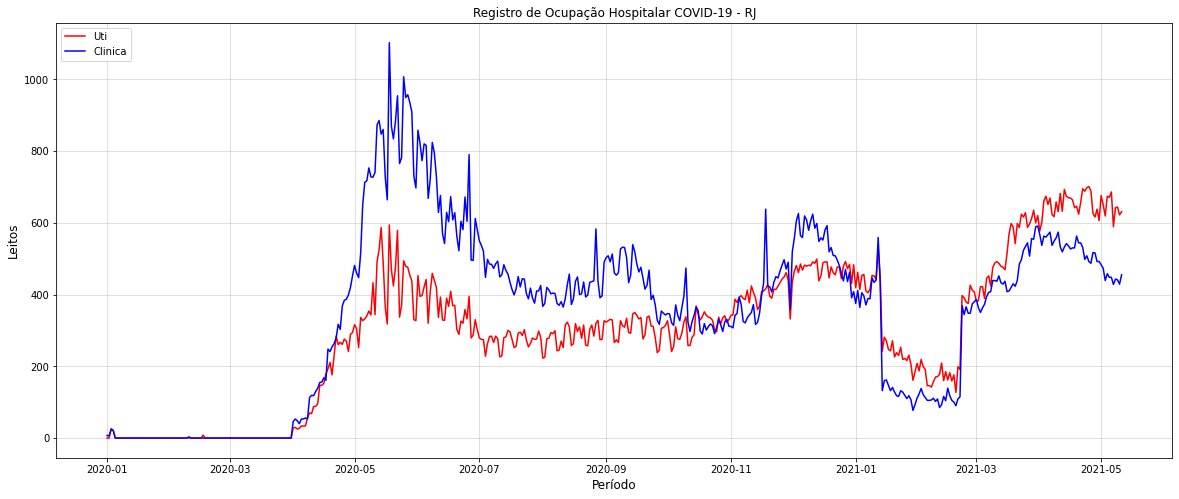

In [24]:
fig,ax= plt.subplots(figsize = (20, 8))
ax.plot(data_sus['ocupacaoConfirmadoUti'], color = "red", label = "Uti")
ax.plot(data_sus['ocupacaoConfirmadoCli'], color = "blue", label = "Clinica")

ax.grid(alpha = .5)
xtick_location = np.arange(0, len(data_sus), step=14)
xtick_labels = data_sus.index.values.astype('M8[D]').tolist()[::14]
#ax.set_xticks(xtick_location)
#ax.set_xticklabels(xtick_labels.values.astype('M8[D]'), rotation=90, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'})
ax.set_ylabel('Leitos',fontsize = 12)
ax.set_xlabel('Período',fontsize = 12)
ax.set_title("Registro de Ocupação Hospitalar COVID-19 - RJ", fontsize = 12)
ax.legend(loc = "upper left", fontsize = 10)
plt.show()

## Variação vírus

https://outbreak.info/location-reports?loc=BRA_BR-RJ&selected=S%3AE484K&selected=B.1.1.7&selected=B.1.351&selected=P.1

In [38]:
lineage_prevalence = pd.read_json (r'data/RJ/outbreakinfo_mutation_report_data_2021-05-26.json')
lineage_prevalence.drop(["source"],axis='columns', inplace=True)
lineage_prevalence = lineage_prevalence.set_index('date_time')
print("Shape of dataset: ", lineage_prevalence.shape)
lineage_prevalence

Shape of dataset:  (413, 3)


,B.1.1.7,Other,P.1
date_time,,,
2020-03-14 03:00:00+00:00,0.0,1.0,0.0
2020-03-15 03:00:00+00:00,0.0,1.0,0.0
2020-03-16 03:00:00+00:00,0.0,1.0,0.0
2020-03-17 03:00:00+00:00,0.0,1.0,0.0
2020-03-18 03:00:00+00:00,0.0,1.0,0.0
...,...,...,...
2021-04-26 03:00:00+00:00,0.0,0.0,1.0
2021-04-27 03:00:00+00:00,0.0,0.0,1.0
2021-04-28 03:00:00+00:00,0.0,0.0,1.0


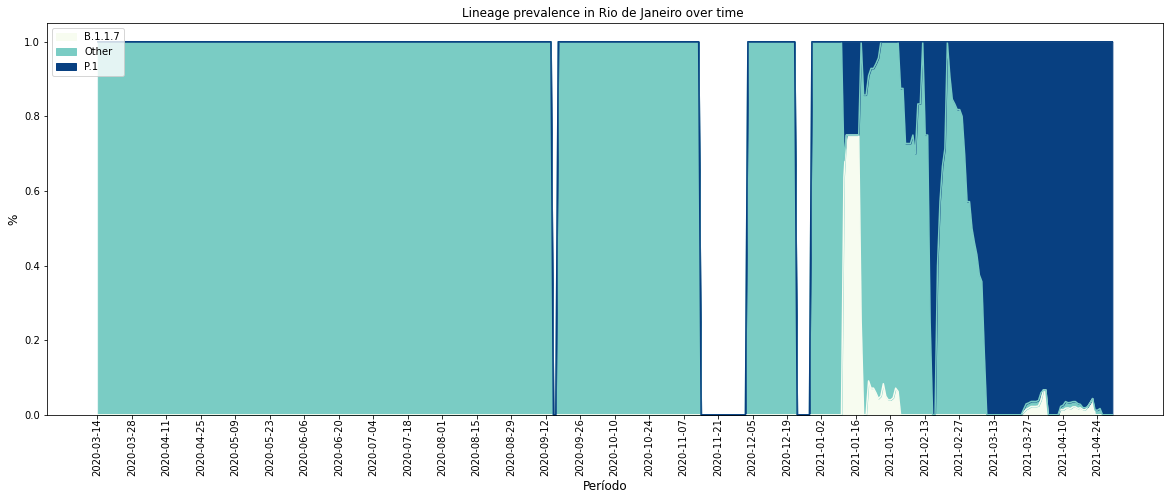

In [39]:

fig,ax= plt.subplots(figsize = (20, 8))
xtick_labels = lineage_prevalence.index.values.astype('M8[D]').tolist()[::14]
lineage_prevalence.plot(kind='area', ax=ax, stacked=True,xticks=xtick_labels, colormap = plt.get_cmap('GnBu'))
ax.set_ylabel('%',fontsize = 12)
ax.set_xticklabels(xtick_labels, rotation=90, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'})
ax.set_xlabel('Período',fontsize = 12)
ax.set_title("Lineage prevalence in Rio de Janeiro over time ", fontsize = 12)
ax.legend(loc = "upper left", fontsize = 10)
plt.show()

## Dados de progressão social RJ

## Dados de Restrições Governamentais


https://www.bsg.ox.ac.uk/research/research-projects/covid-19-government-response-tracker

In [27]:
gov_resp_tracker = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
response = requests.get(gov_resp_tracker).content


In [28]:
fields = ["CountryName","CountryCode","RegionCode","Jurisdiction" ]

data_tracker = pd.read_csv(gov_resp_tracker, low_memory=False)
#data_tracker = pd.read_csv('data/RJ/OxCGRT_latest.csv',low_memory=False)
data_tracker.drop(fields,axis='columns',inplace=True)

In [29]:

data_tracker['Date'] = pd.to_datetime(data_tracker['Date'],format='%Y%m%d')
data_tracker = data_tracker.set_index('Date')
tracker_data = data_tracker.query('RegionName == "Rio de Janeiro"') 
tracker_data

,RegionName,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,...,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,Rio de Janeiro,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,Rio de Janeiro,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,Rio de Janeiro,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,Rio de Janeiro,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,Rio de Janeiro,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-22,Rio de Janeiro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-23,Rio de Janeiro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-24,Rio de Janeiro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


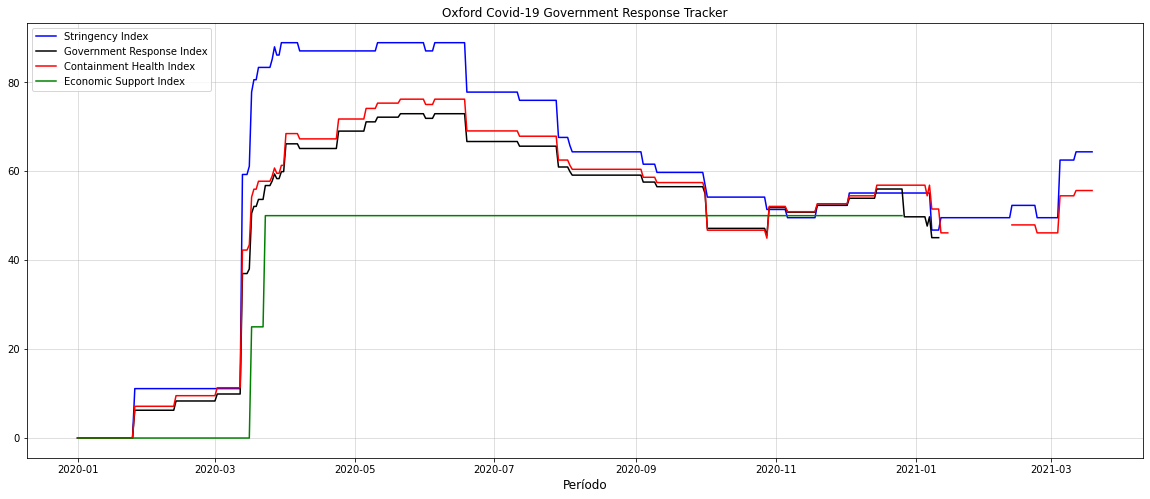

In [30]:
fig,ax= plt.subplots(figsize = (20, 8))
ax.plot(tracker_data['StringencyIndexForDisplay'], color = "blue", label = "Stringency Index")
ax.plot(tracker_data['GovernmentResponseIndexForDisplay'], color = "black", label = "Government Response Index")
ax.plot(tracker_data['ContainmentHealthIndexForDisplay'], color = "red", label = "Containment Health Index")
ax.plot(tracker_data['EconomicSupportIndexForDisplay'], color = "green", label = "Economic Support Index")
ax.grid(alpha = .5)

ax.set_xlabel('Período',fontsize = 12)
ax.set_title("Oxford Covid-19 Government Response Tracker", fontsize = 12)
ax.legend(loc = "upper left", fontsize = 10)
plt.show()

Each of these indices report a number between 0 to 100 that reflects the level of the governments response along certain dimensions. This is a measure of how many of the relevant indicators a government has acted upon, and to what degree. The index cannot say whether a government's policy has been implemented effectively. (https://github.com/OxCGRT/covid-policy-tracker)

    - overall government response index (all indicators)
    - containment and health index (all C and H indicators)
    - stringency index (all C indicators, plus H1 which records public information campaigns)
    - economic support index (all E indicators)
